# Calibration scores

how to deal with different threshold?
-> scale confidences according to threshold range, such that confidences are always between 0.5 - 1.
E.g. if threshold = 0.2, confidence will be in range 0.2 - 1 -> rescale them to be in 0.5 - 1

TODO: calculate ECE per class
TODO: calculate per cluster scores - entropy-based score proposed in https://arxiv.org/pdf/1911.13273.pdf
TODO: research other ways to calculate per cluster scores

In [80]:
from meld_graph.evaluation import load_prediction
from meld_graph.experiment import Experiment
import h5py
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Initialised Experiment 23-06-05_RMRC_low_smooth_regress_RC/s_0


ECE:  0.0035563847367135067
[0.004983659120601048, 0.20826314389573544, 0.3352881698685541, 0.47490494296577945, 0.5172413793103449, 0.5861405197305101, 0.6732522796352584, 0.7746350364963503, 0.8823061630218688, 0.4838709677419355] [0.9950163408793989, 0.7917368561042646, 0.6647118301314459, 0.5250950570342205, 0.4827586206896552, 0.5861405197305101, 0.6732522796352584, 0.7746350364963503, 0.8823061630218688, 0.4838709677419355] [0.9970654026930251, 0.7170133672186284, 0.5110318690387737, 0.3056970171148786, 0.10201659079255729, 0.0840587791510794, 0.3062670917496493, 0.5140977413767446, 0.707638731675878, 0.8307547088592283] [0.9910402853603082, 0.003838953860396727, 0.0016830948523505467, 0.0008951545928578236, 0.0006514547113041347, 0.0003536371186232999, 0.0002239588296959878, 0.0003730378075179371, 0.0008560128521054853, 8.441001483982518e-05]


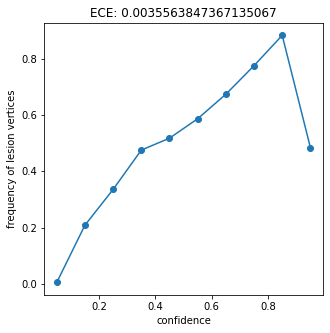

In [142]:
# ensemble - need to rerun
model_name = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-06-05_RMRC_low_smooth_regress_RC/s_0/fold_all'
# single model
model_name = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-06-05_RMRC_low_smooth_regress_RC/s_0/fold_01'

#model_name = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-06-30_RQWV_raw_no_combat/s_0/fold_all'
exp = Experiment.from_folder(model_name)
features = exp.data_parameters['features']
cohort = exp.cohort

prediction_fname = os.path.join(model_name, 'results/predictions.hdf5')
subjects = list(h5py.File(prediction_fname, 'r').keys())

threshold = 0.5
results_dict = get_confidence(subjects[:10], prediction_fname, threshold=threshold)
results_dict = get_lesion(subjects[:10], cohort, results_dict=results_dict)

freq, acc, conf, n = calibration_plot(results_dict)
print(freq, acc, conf, n)

In [138]:
def get_confidence(subjects, prediction_fname, threshold=0.5, results_dict=None):
    """
    confidence: prediction
    confidence2: 1-prediction for non-lesion examples, scaled such that confidence at threshold is 0.5
    """
    if results_dict is None:
        results_dict = {}
    min1 = threshold
    min2 = 1-threshold
    results_dict = {}
    for subj_id in subjects:
        if subj_id not in results_dict.keys():
            results_dict[subj_id] = {}
        prediction = load_prediction(subj_id, prediction_fname, dset="prediction")
        prediction = np.concatenate([prediction['lh'], prediction['rh']])
        results_dict[subj_id]['prediction'] = prediction
        results_dict[subj_id]['confidence'] = prediction
        confidence = (prediction > threshold)*((prediction-min1)/(1-min1)) \
                    +(prediction <= threshold)*((1-prediction-min2)/(1-min2))
        results_dict[subj_id]['confidence2'] = confidence
    return results_dict

def get_lesion(subjects, cohort, results_dict=None):
    if results_dict is None:
        results_dict = {}
    for subj_id in subjects:
        if subj_id not in results_dict.keys():
            results_dict[subj_id] = {}
        subj = MeldSubject(subj_id, cohort=cohort)
        results_dict[subj_id]['lesion'] = np.concatenate([
            np.ceil(subj.load_feature_values(".on_lh.lesion.mgh", hemi='lh')).astype(int)[cohort.cortex_mask],
            np.ceil(subj.load_feature_values(".on_lh.lesion.mgh", hemi='rh')).astype(int)[cohort.cortex_mask]])
    return results_dict
        
def calibration_plot(results_dict, n_bins=10, threshold=0.5):
    """
    calculate ECE as described in literature
    calclulate calibration plot as calculated by sklearn.calibration
    """
    # sort all results in bins according to confidence score
    bins = np.linspace(0,1,n_bins+1)
    binned_prediction = {bin_idx: np.array([]) for bin_idx in range(len(bins[:-1]))}
    binned_confidence = {bin_idx: np.array([]) for bin_idx in range(len(bins[:-1]))}
    binned_confidence2 = {bin_idx: np.array([]) for bin_idx in range(len(bins[:-1]))}
    binned_lesion = {bin_idx: np.array([]) for bin_idx in range(len(bins[:-1]))}
    for subj_results in results_dict.values():
        for bin_idx in binned_prediction.keys():
            bin_min = bins[bin_idx]
            bin_max = bins[bin_idx+1]
            # get idx of all vertices in current bin (according to confidence)
            mask = (subj_results['confidence'] > bin_min) & (subj_results['confidence'] <= bin_max)
            binned_prediction[bin_idx] = np.concatenate([binned_prediction[bin_idx], subj_results['prediction'][mask]])
            binned_lesion[bin_idx] = np.concatenate([binned_lesion[bin_idx], subj_results['lesion'][mask]])
            binned_confidence[bin_idx] = np.concatenate([binned_confidence[bin_idx], subj_results['confidence'][mask]])
            binned_confidence2[bin_idx] = np.concatenate([binned_confidence2[bin_idx], subj_results['confidence2'][mask]])
    
    # calculate accuracy as frequency of positive labels in each bin
    # use confidence2 for confidence estimates for the ECE here which contains 1-conf for predictions > threshold,
    # because otherwise confidence estimates for lower bins are very high, because of all the non-lesional examples
    freq = []
    acc = []
    conf = []
    n = []
    for bin_idx in binned_prediction.keys():
        freq.append(binned_lesion[bin_idx].sum()/len(binned_lesion[bin_idx]))
        conf.append(binned_confidence2[bin_idx].sum()/len(binned_lesion[bin_idx]))
        acc.append(((binned_prediction[bin_idx] > threshold) == binned_lesion[bin_idx]).sum() / len(binned_lesion[bin_idx]))
        n.append(len(binned_prediction[bin_idx]) / sum([len(binned_prediction[i]) for i in binned_prediction.keys()]))
    ece = (np.abs(np.array(acc) - np.array(conf))*np.array(n)).sum()
    print('ECE: ', ece)
        
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(bins[:-1] + (bins[1:]-bins[:-1])/2, freq, 'o-')
    ax.set_xlabel('confidence')
    ax.set_ylabel('frequency of lesion vertices')
    ax.set_title('ECE: {}'.format(ece))
    return freq, acc, conf, n
        



ECE:  0.0035563847367135067
[0.004983659120601048, 0.20826314389573544, 0.3352881698685541, 0.47490494296577945, 0.5172413793103449, 0.5861405197305101, 0.6732522796352584, 0.7746350364963503, 0.8823061630218688, 0.4838709677419355] [0.9950163408793989, 0.7917368561042646, 0.6647118301314459, 0.5250950570342205, 0.4827586206896552, 0.5861405197305101, 0.6732522796352584, 0.7746350364963503, 0.8823061630218688, 0.4838709677419355] [0.9970654026930251, 0.7170133672186284, 0.5110318690387737, 0.3056970171148786, 0.10201659079255729, 0.0840587791510794, 0.3062670917496493, 0.5140977413767446, 0.707638731675878, 0.8307547088592283] [0.9910402853603082, 0.003838953860396727, 0.0016830948523505467, 0.0008951545928578236, 0.0006514547113041347, 0.0003536371186232999, 0.0002239588296959878, 0.0003730378075179371, 0.0008560128521054853, 8.441001483982518e-05]


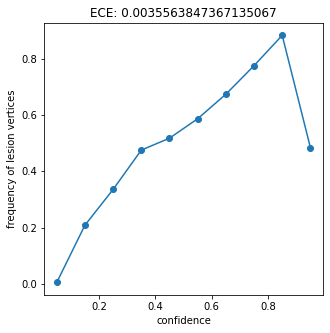

In [137]:
threshold = 0.5
results_dict = get_confidence(subjects[:10], prediction_fname, threshold=threshold)
results_dict = get_lesion(subjects[:10], cohort, results_dict=results_dict)
     
freq, acc, conf, n = calibration_plot(results_dict)
print(freq, acc, conf, n)

In [65]:
np.arange(0,1,10)

array([0])

In [74]:
def f(x, t=0.1):
    a = (0.5 - t) / (t**2 - t)
    b = 1 - a
    print(a, b, a+b)
    return a*(x**2)+b*x

print(np.arange(0,1.1,0.1))
print(f(np.arange(0,1.1,0.1), t=0.1))
    

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
-4.444444444444445 5.444444444444445 1.0
[0.         0.5        0.91111111 1.23333333 1.46666667 1.61111111
 1.66666667 1.63333333 1.51111111 1.3        1.        ]


In [12]:
prediction = load_prediction(subjects[0], prediction_fname, dset="prediction")

In [19]:
subj = MeldSubject(subjects[0], cohort=cohort)
lesion = {'lh': np.ceil(subj.load_feature_values(".on_lh.lesion.mgh", hemi='lh')).astype(int),
          'rh': np.ceil(subj.load_feature_values(".on_lh.lesion.mgh", hemi='rh')).astype(int)}

In [22]:
confidence = prediction

In [25]:
n_bins = 10
bins = np.linspace(0,1,n_bins+1)

In [27]:
confidence

{'lh': array([1.3641655e-04, 9.9381446e-05, 2.1156837e-04, ..., 1.4658827e-04,
        1.5292244e-04, 1.5593530e-04], dtype=float32),
 'rh': array([4.22070334e-05, 1.22465659e-04, 1.08821972e-04, ...,
        1.11777423e-04, 1.06398074e-04, 9.93501744e-05], dtype=float32)}